In [1]:
import pyhf
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/BkgOnly.json > lhood.json

x RegionA/BkgOnly.json


### Create the Model and Fit it

In [3]:
def make_model(channel_list):
    spec = json.load(open("lhood.json"))
    spec = copy.copy(spec)
    spec["channels"] = [c for c in spec["channels"] if c["name"] in channel_list]
    spec["measurements"][0]["config"]["poi"] = "lumi"

    w = pyhf.Workspace(spec)
    m = w.model(
        measurement_name="NormalMeasurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    d = w.data(m)
    return w, m, d


def fitresults(constraints=None):
    _, model, data = make_model(["CRtt_meff"])

    pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True))
    result = pyhf.infer.mle.fit(
        data,
        model,
        fixed_vals = constraints,
        return_uncertainties =  True
    )
    bestfit = result[:,0]
    errors = result[:,1]
    return model, data, bestfit, errors



m, data, bestfit, errors = fitresults()

## Normalize to natural width and order results

In [4]:
pulls = pyhf.tensorlib.concatenate(
    [
        (bestfit[m.config.par_slice(k)] - m.config.param_set(k).suggested_init)
        / m.config.param_set(k).width()
        for k in m.config.par_order
        if m.config.param_set(k).constrained
    ]
)
pullerr = pyhf.tensorlib.concatenate(
    [
        errors[m.config.par_slice(k)] / m.config.param_set(k).width()
        for k in m.config.par_order
        if m.config.param_set(k).constrained
    ]
)
labels = np.asarray(
    [
        "{}[{}]".format(k, i) if m.config.param_set(k).n_parameters > 1 else k
        for k in m.config.par_order
        if m.config.param_set(k).constrained
        for i in range(m.config.param_set(k).n_parameters)
    ]
)

order = np.argsort(labels)
fitted = bestfit[order]
fiterr = errors[order]
labels = labels[order]
pulls = pulls[order]
pullerr = pullerr[order]

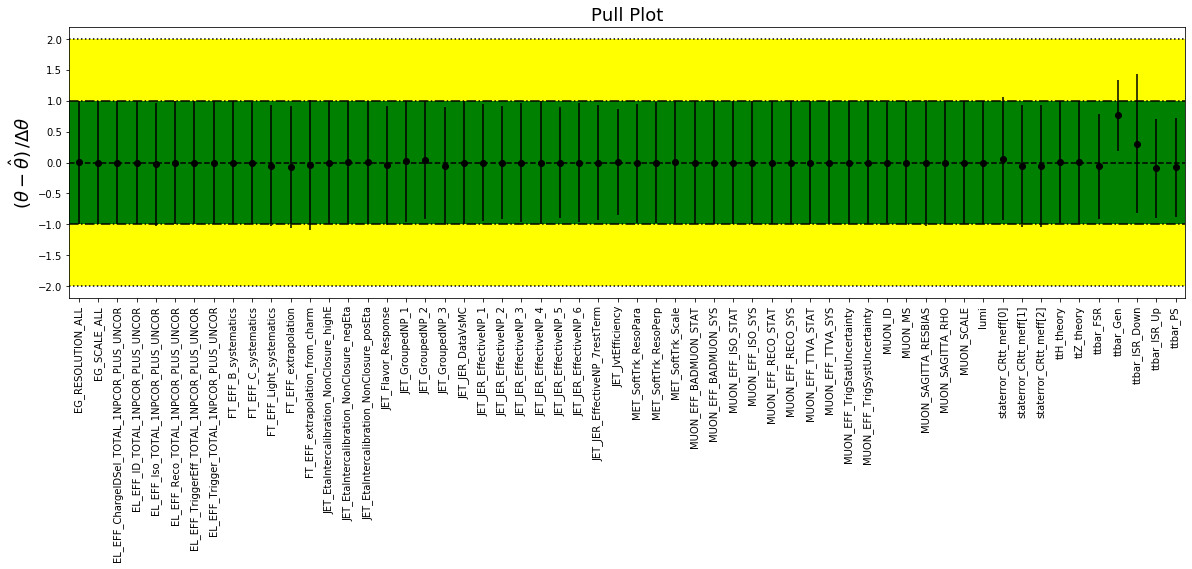

In [5]:
plt.hlines([-2, 2], -0.5, len(pulls) - 0.5, colors="k", linestyles="dotted")
plt.hlines([-1, 1], -0.5, len(pulls) - 0.5, colors="k", linestyles="dashdot")
plt.fill_between([-0.5, len(pulls) - 0.5], [-2, -2], [2, 2], facecolor="yellow")
plt.fill_between([-0.5, len(pulls) - 0.5], [-1, -1], [1, 1], facecolor="green")
plt.hlines([0], -0.5, len(pulls) - 0.5, colors="k", linestyles="dashed")
plt.scatter(range(len(pulls)), pulls, c="k")
plt.errorbar(
    range(len(pulls)), pulls, c="k", xerr=0, yerr=pullerr, marker=".", fmt="none"
)
plt.xticks(range(len(pulls)), labels, rotation=90)
plt.gcf().set_size_inches(20, 5)
plt.xlim(-0.5, len(pulls) - 0.5)
plt.title("Pull Plot", fontsize=18)
plt.ylabel(r"$(\theta - \hat{\theta})\,/ \Delta \theta$", fontsize=18);